In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, asc, desc

In [4]:
# save filepath to hawaii.sqlite file
db = "../Resources/hawaii.sqlite"

In [5]:
# create engine for database
engine = create_engine(f"sqlite:///{db}")

In [6]:
# create inspector object
inspector = inspect(engine)

In [7]:
# return list of tables in database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# create a new class using automap_base
Base = automap_base()

In [9]:
# use new class to reflect the database tables
Base.prepare(autoload_with=engine)

In [10]:
# return all tables mapped to Base class
Base.classes.keys()

['measurement', 'station']

In [11]:
# assign measurement to "Measurement" variable. Creates Measurement object
Measurement = Base.classes.measurement

In [12]:
# assign station to "Station" variable. Creates Station object
Station = Base.classes.station

In [13]:
# create session object
session = Session(engine)

## Preview table structure, data types

In [14]:
# preview columns in Measurement table
columns = inspector.get_columns("Measurement")

for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# preview columns in Station table
columns_2 = inspector.get_columns("Station")

for c in columns_2:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [16]:
# return most recent date from measurement table
last_date = session.query(Measurement.date).distinct().\
    order_by(Measurement.date.desc()).first()

last_date

## can also return date using engine.execute
# query = 'SELECT distinct date FROM measurement ORDER BY date DESC'
# latest_date = engine.execute(query).first()
# print(latest_date)

('2017-08-23',)

In [17]:
# find earliest date -- 1yr prior to last_date
earliest_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(earliest_date)

2016-08-23


In [18]:
# query measurement table - precipitation data for 12 months prior to last date
total_prcp = [Measurement.date, Measurement.prcp]

last_year = session.query(*total_prcp) .\
    filter(Measurement.date >= dt.date(2017, 8, 23) - dt.timedelta(days=365)) .\
    filter(Measurement.prcp != 'NaN') .\
    order_by(asc(Measurement.date)).all()

In [19]:
# create Dataframe based on query results
df_lastyear = pd.DataFrame(last_year, columns = ['Date', 'Precipitation'])

# sort DataFrame
df_lastyear = df_lastyear.sort_index()

# set index to Date column
df_lastyear.set_index(df_lastyear['Date'],inplace=True )

# format DataFrame
df_lastyear.index.name = None

# preview DataFrame
df_lastyear

,Date,Precipitation
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.15
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.02
2016-08-23,2016-08-23,1.79
...,...,...
2017-08-22,2017-08-22,0.50
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.08


In [20]:
## create a separate dataframe to determine values to use for xticklabels -- to match sample image

# count number of records associated with each date
count = df_lastyear.groupby(['Date']).count()

# create DataFrame with count by date
df_count = pd.DataFrame(count)

# reset DataFrame row index
df_count.reset_index(inplace=True)

# rename columns in DataFrame
df_count = df_count.rename(columns = {'Precipitation': '# Records'})

# add a column to show the cumulative record count for each date
df_count['Cumulative Records'] = df_count['# Records'].cumsum()

# add a column to for xticks - the cumulative sum - 1 for each date
df_count["xticks"] = df_count["Cumulative Records"] - 1

# format DataFrame
df_count.index.name = None

In [21]:
# filter df_count to only disply rows to match dates associated with sample image

dates_graph = ['2016-08-23', '2016-10-01', '2016-11-09', 
               '2016-12-19', '2017-01-28', '2017-03-09',
               '2017-04-18', '2017-05-31', '2017-07-10']

df_count = df_count.loc[df_count['Date'].isin(dates_graph)]

df_count

,Date,# Records,Cumulative Records,xticks
0,2016-08-23,6,6,5
39,2016-10-01,6,232,231
78,2016-11-09,7,460,459
118,2016-12-19,6,684,683
158,2017-01-28,5,907,906
198,2017-03-09,6,1134,1133
238,2017-04-18,7,1359,1358
281,2017-05-31,5,1593,1592
321,2017-07-10,6,1813,1812


In [22]:
# remove duplicate date column (since set as index)
df_lastyear = df_lastyear.drop(columns = ["Date"])

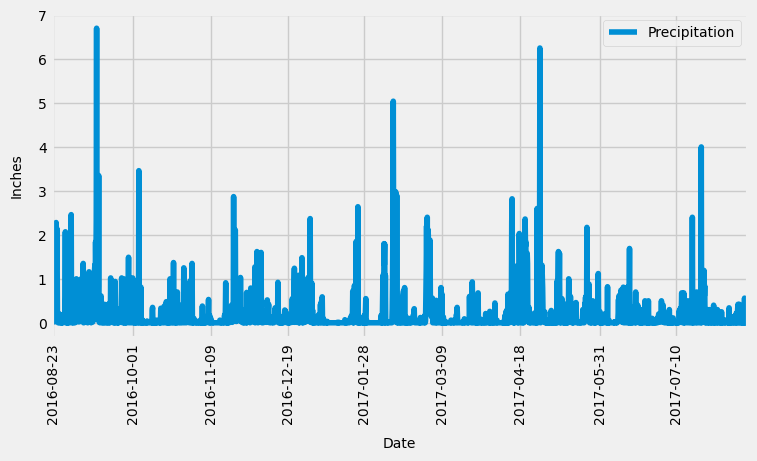

In [23]:
# create line plot to chart precipitation data for last year

fig, ax = plt.subplots(figsize = (8,4))
df_lastyear['Precipitation'].plot(kind='line',
        linewidth = 4, 
        xticks = (0, 231, 459, 683, 906, 1133, 1358, 1592, 1812), ax = ax)
plt.xticks(rotation = 90, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Date', fontsize = 10, labelpad = 10)
plt.ylabel('Inches', fontsize = 10, labelpad = 10)
plt.xlim(-5, 2022)
plt.legend(loc = "upper right", fontsize = 10)
plt.show()

In [24]:
# calculate the summary statistics for the precipitation data
df_lastyear.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Measurement.station).distinct().count()

number_stations

9

In [26]:
# return number of stations and record count associated with each station
activity = (session.query(Measurement.station, func.count(Measurement.station))
            .group_by(Measurement.station)
            .order_by(func.count(Measurement.station).desc())
            .all())

activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temps = [Measurement.station, 
         func.min(Measurement.tobs),
         func.max(Measurement.tobs),
         func.avg(Measurement.tobs)]

active_station = (session.query(*temps)
                 .filter(Measurement.station == 'USC00519281') \
                 .group_by(Measurement.station)
                 .all())

In [28]:
# read result of query into DataFrame using station as index
active_station_df = pd.DataFrame(active_station, columns = ['station', 'min_temp', 
                                                         'max_temp', 'avg_temp'])

active_station_df.set_index('station', inplace = True)

# format DataFrame
active_station_df.index.name = None

# display DataFrame
active_station_df

,min_temp,max_temp,avg_temp
USC00519281,54.0,85.0,71.663781


In [29]:
# find latest date - for most active station
last_date_USC00519281 = session.query(Measurement.date).distinct()\
    .filter(Measurement.station == 'USC00519281')\
    .order_by(Measurement.date.desc()).first()

print(last_date_USC00519281)

('2017-08-18',)


In [30]:
# find earliest date -- 1yr prior to last_date
temp_start_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)

print(temp_start_date)

2016-08-18


In [31]:
# query measument data for temperatures associated with most active station for year prior to 2017-08-18

last_year_temps = (session.query(Measurement.date, (Measurement.tobs))
                  .filter(Measurement.date >= dt.date(2017, 8, 18) - dt.timedelta(days=365))
                  .filter(Measurement.station == 'USC00519281')
                  .all())

In [32]:
# read query result object to DataFrame
temps_df = pd.DataFrame(last_year_temps)

# set row index to date
temps_df.set_index('date', inplace = True)

# format DataFrame
temps_df.index.name = None

# preview DataFrame
temps_df.head()

,tobs
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


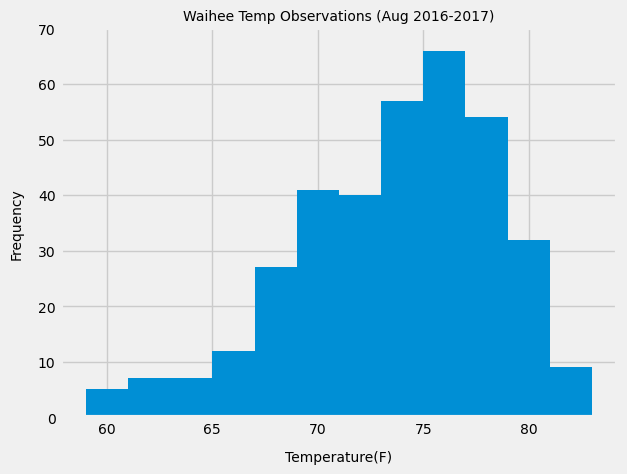

In [33]:
# plot histogram of temperature data for most active station

plt.hist(temps_df['tobs'],
        bins=12)

plt.title('Waihee Temp Observations (Aug 2016-2017)', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10, labelpad = 10)
plt.ylim(0,70)
plt.yticks(fontsize = 10)

plt.xticks(fontsize = 10)
plt.xlabel('Temperature(F)', fontsize = 10, labelpad = 10)

plt.show()

# Close session

In [34]:
# Close Session
session.close()